## **Part 1: Setup and Installation**

In [ ]:
# Install required libraries
!pip install -q transformers datasets torch sklearn pandas matplotlib seaborn
!pip install -q accelerate  # Required for current Hugging Face Trainer
!pip install --upgrade datasets huggingface_hub fsspec

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# **Part 2: Data Loading and Preprocessing**

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]


Training samples: 25000
Test samples: 25000

Sample training data:
                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0


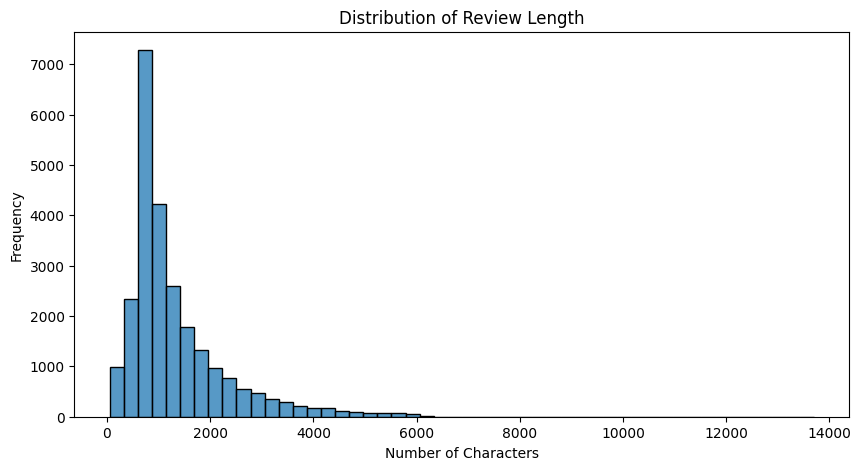

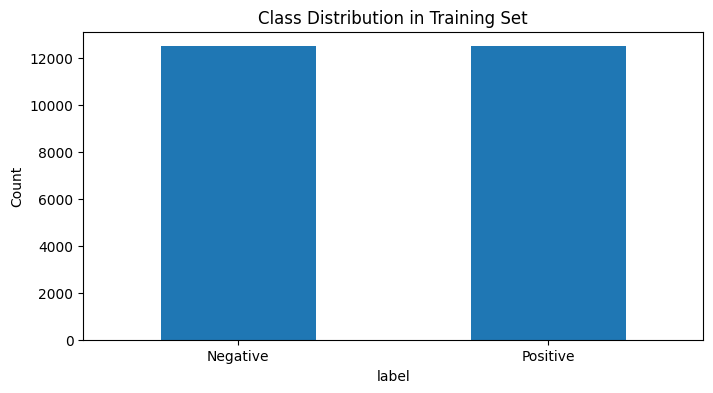

In [ ]:

# Load and explore the IMDb dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset



# Load with streaming mode which might avoid the filesystem issue
dataset = load_dataset('imdb', streaming=True)

# If you need the full dataset (not streamed), try:
dataset = load_dataset('imdb', download_mode="force_redownload")

# Convert to pandas DataFrames
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

# Display basic info
print("\nTraining samples:", len(train_df))
print("Test samples:", len(test_df))
print("\nSample training data:")
print(train_df.head(3))

# Visualize review length distribution
train_df['text_length'] = train_df['text'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(train_df['text_length'], bins=50)
plt.title('Distribution of Review Length')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Visualize class balance
plt.figure(figsize=(8, 4))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Training Set')
plt.xticks([0, 1], ['Negative', 'Positive'], rotation=0)
plt.ylabel('Count')
plt.show()

# **Part 3: Tokenization**

In [ ]:

# Prepare text for BERT using Hugging Face tokenizer

from transformers import BertTokenizer

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Sample tokenization
sample_text = "This movie was absolutely wonderful!"
print("Original text:", sample_text)
print("Tokenized:", tokenizer.tokenize(sample_text))
print("Token IDs:", tokenizer.encode(sample_text))

# Tokenization function
def tokenize_function(batch):
    return tokenizer(
        batch['text'],
        padding='max_length',
        truncation=True,
        max_length=256,
        return_tensors='pt'
    )

# Apply to dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Rename columns for Trainer compatibility
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Show processed example
print("\nTokenized example structure:")
print({k: tokenized_datasets['train'][0][k] for k in ['input_ids', 'attention_mask', 'labels']})

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Original text: This movie was absolutely wonderful!
Tokenized: ['this', 'movie', 'was', 'absolutely', 'wonderful', '!']
Token IDs: [101, 2023, 3185, 2001, 7078, 6919, 999, 102]


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]


Tokenized example structure:
{'input_ids': tensor([  101,  1045, 12524,  1045,  2572,  8025,  1011,  3756,  2013,  2026,
         2678,  3573,  2138,  1997,  2035,  1996,  6704,  2008,  5129,  2009,
         2043,  2009,  2001,  2034,  2207,  1999,  3476,  1012,  1045,  2036,
         2657,  2008,  2012,  2034,  2009,  2001,  8243,  2011,  1057,  1012,
         1055,  1012,  8205,  2065,  2009,  2412,  2699,  2000,  4607,  2023,
         2406,  1010,  3568,  2108,  1037,  5470,  1997,  3152,  2641,  1000,
         6801,  1000,  1045,  2428,  2018,  2000,  2156,  2023,  2005,  2870,
         1012,  1026,  7987,  1013,  1028,  1026,  7987,  1013,  1028,  1996,
         5436,  2003,  8857,  2105,  1037,  2402,  4467,  3689,  3076,  2315,
        14229,  2040,  4122,  2000,  4553,  2673,  2016,  2064,  2055,  2166,
         1012,  1999,  3327,  2016,  4122,  2000,  3579,  2014,  3086,  2015,
         2000,  2437,  2070,  4066,  1997,  4516,  2006,  2054,  1996,  2779,
        25430, 14728

# **Part 4: Model Initialization**

In [ ]:

# Load pre-trained BERT with classification head

from transformers import BertForSequenceClassification

# Initialize model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2  # Binary classification
)

# Print model architecture
print("Model architecture:")
print(model)

# Explain parameters
print("\nTotal parameters:", sum(p.numel() for p in model.parameters()))
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model architecture:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

# **Part 5: Training Setup**

In [ ]:

# Configure training arguments and metrics

from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Reduce dataset size for faster demo
small_train_dataset = tokenized_datasets['train'].shuffle(seed=42).select(range(2000))
small_eval_dataset = tokenized_datasets['test'].shuffle(seed=42).select(range(500))

# Metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary')

    return {'accuracy': acc, 'f1': f1}

# Training configuration
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    eval_strategy="epoch",  # Older versions used this name
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics
)

# **Part 6: Model Training**

In [ ]:

# Fine-tune BERT on our dataset

# Start training
print("Starting training...")
train_results = trainer.train()

# Save model
trainer.save_model('./sentiment_model')
tokenizer.save_pretrained('./sentiment_model')

# Training metrics
print("\nTraining completed. Metrics:")
print(pd.DataFrame([train_results.metrics]))

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting training...


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mk23aeb (mk23aeb-university-of-hertfordshire) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.433100,0.323237,0.856000,0.854251
2,0.521800,0.902463,0.750000,0.791319
3,0.246200,0.466122,0.896000,0.896825



Training completed. Metrics:
   train_runtime  train_samples_per_second  train_steps_per_second  \
0       343.4166                    17.471                   2.184   

     total_flos  train_loss  epoch  
0  7.893332e+14    0.374196    3.0  


# **Part 7: Evaluation**

Evaluating on test set...



Test set performance:
Accuracy: 0.8310
F1 Score: 0.0000


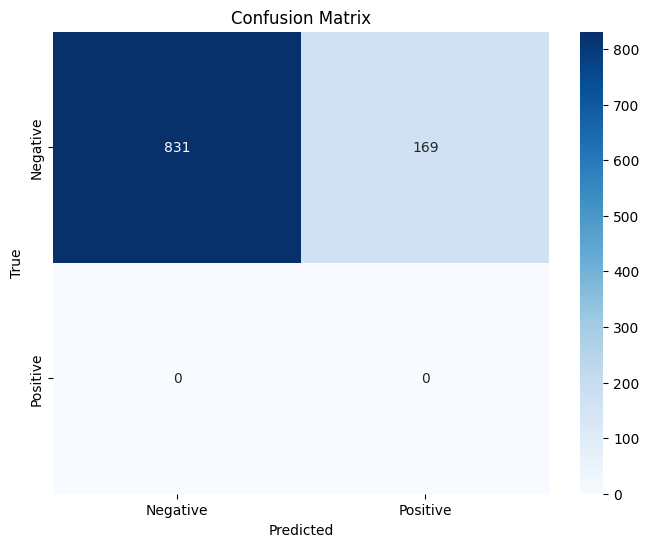


Sample misclassified reviews:

Example 1:
Text: STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning <br /><br />Former New Orleans homicide cop Jack Robideaux (Jean Claude Van Damme) is re-assigne...
True: Negative, Predicted: Positive

Example 2:
Text: First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy thes...
True: Negative, Predicted: Positive

Example 3:
Text: Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces and Undisputed 2 are all action classics. You can te...
True: Negative, Predicted: Positive


In [ ]:

# Evaluate model performance

# Full evaluation on test set
print("Evaluating on test set...")
eval_results = trainer.evaluate(tokenized_datasets['test'].select(range(1000)))
print("\nTest set performance:")
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"F1 Score: {eval_results['eval_f1']:.4f}")

# Confusion matrix
predictions = trainer.predict(tokenized_datasets['test'].select(range(1000)))
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

# Error analysis: Misclassified examples
test_subset = tokenized_datasets['test'].select(range(1000))
misclassified = []
for i in range(len(preds)):
    if preds[i] != labels[i]:
        text = dataset['test']['text'][i]
        misclassified.append({
            'text': text,
            'true_label': 'Positive' if labels[i] == 1 else 'Negative',
            'predicted_label': 'Positive' if preds[i] == 1 else 'Negative'
        })

print("\nSample misclassified reviews:")
for i, example in enumerate(misclassified[:3]):
    print(f"\nExample {i+1}:")
    print(f"Text: {example['text'][:200]}...")
    print(f"True: {example['true_label']}, Predicted: {example['predicted_label']}")

# **Part 8: Inference Demonstration**

In [ ]:
import torch  # For CUDA device check
import pandas as pd  # For DataFrame
from IPython.display import display  # For pretty display in notebook

# Test model with custom inputs

from transformers import pipeline

# Create sentiment analysis pipeline
classifier = pipeline(
    'text-classification',
    model='./sentiment_model',
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

# Sample reviews
sample_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot was incredibly engaging from start to finish.",
    "A complete waste of time. I've never seen such poor acting and disjointed storytelling in my life.",
    "While the cinematography was beautiful, the characters felt underdeveloped and the pacing was too slow.",
    "This is the best film I've seen this year. The director's vision was executed perfectly by the entire cast.",
    "I expected so much more from this acclaimed director. The plot holes were big enough to drive a truck through."
]

# Run predictions
results = classifier(sample_reviews)

# Display results
print("\nSample Predictions:")
for i, (review, result) in enumerate(zip(sample_reviews, results)):
    sentiment = 'Positive' if result['label'] == 'LABEL_1' else 'Negative'
    print(f"\nReview {i+1}:")
    print(f"Text: {review[:100]}...")
    print(f"Sentiment: {sentiment} (Confidence: {result['score']:.4f})")

# Create comparison table
comparison_df = pd.DataFrame({
    'Review': [r[:80] + "..." for r in sample_reviews],
    'Prediction': ['Positive' if r['label'] == 'LABEL_1' else 'Negative' for r in results],
    'Confidence': [r['score'] for r in results]
})
print("\nPrediction Summary Table:")
display(comparison_df)

Device set to use cuda:0



Sample Predictions:

Review 1:
Text: This movie was absolutely fantastic! The acting was superb and the plot was incredibly engaging from...
Sentiment: Positive (Confidence: 0.9964)

Review 2:
Text: A complete waste of time. I've never seen such poor acting and disjointed storytelling in my life....
Sentiment: Negative (Confidence: 0.9960)

Review 3:
Text: While the cinematography was beautiful, the characters felt underdeveloped and the pacing was too sl...
Sentiment: Negative (Confidence: 0.9964)

Review 4:
Text: This is the best film I've seen this year. The director's vision was executed perfectly by the entir...
Sentiment: Positive (Confidence: 0.9964)

Review 5:
Text: I expected so much more from this acclaimed director. The plot holes were big enough to drive a truc...
Sentiment: Negative (Confidence: 0.9670)

Prediction Summary Table:


,Review,Prediction,Confidence
0,This movie was absolutely fantastic! The actin...,Positive,0.996404
1,A complete waste of time. I've never seen such...,Negative,0.995963
2,"While the cinematography was beautiful, the ch...",Negative,0.996399
3,This is the best film I've seen this year. The...,Positive,0.996442
4,I expected so much more from this acclaimed di...,Negative,0.967048


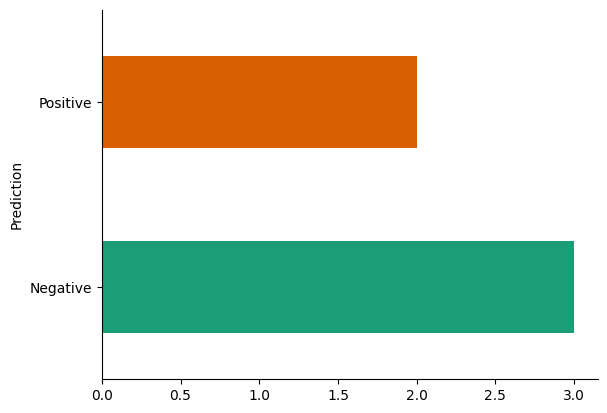

In [ ]:
#Prediction

from matplotlib import pyplot as plt
import seaborn as sns
comparison_df.groupby('Prediction').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

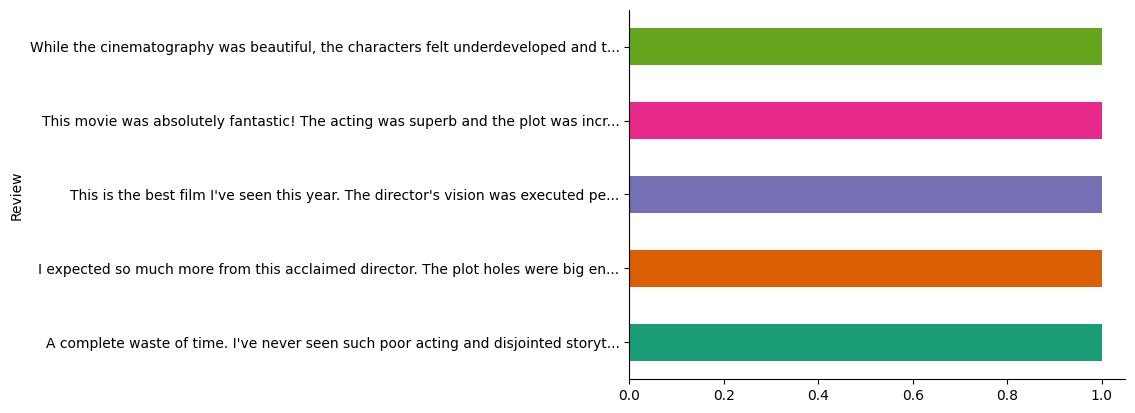

In [ ]:
# Review

from matplotlib import pyplot as plt
import seaborn as sns
comparison_df.groupby('Review').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

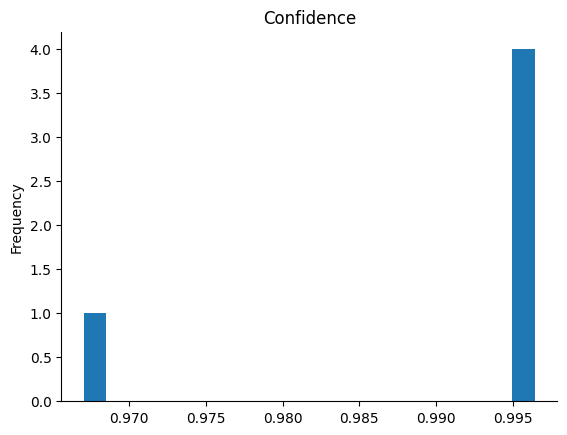

In [ ]:
# Confidence

from matplotlib import pyplot as plt
comparison_df['Confidence'].plot(kind='hist', bins=20, title='Confidence')
plt.gca().spines[['top', 'right',]].set_visible(False)